In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
num_samples = 10000
max_sequence_length = 100
max_num_words = 20000

In [43]:
def load_data(file_name):
    t = 0
    input_texts = []
    target_texts = []
    target_texts_inputs = []
    with open(file_name,  'r') as f:
        for line in f:
            t+=1
            if t > num_samples:
                break

            if '\t' not in line:
                continue

            input_text, translation = line.rstrip().split('\t')


            translation = translation.strip('\n')

            target_text = translation + ' E'
            target_text_input = 'S ' + translation

            input_texts.append(input_text)
            target_texts.append(target_text)
            target_texts_inputs.append(target_text_input)
    return input_texts, target_texts, target_texts_inputs

In [44]:
input_texts, target_texts, target_texts_inputs = load_data("data/cmn.txt")

print(len(input_texts))
print(len(target_texts))
print(len(target_texts_inputs))

10000
10000
10000


### Tokenize the inputs

In [45]:
tokenizer_inputs = Tokenizer(num_words=max_num_words)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [46]:
max_len_input = max(len(s) for s in input_sequences)
print('max_len_input:', max_len_input)

max_len_input: 9


In [47]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found {0} unique input token'.format(len(word2idx_inputs)))

Found 3570 unique input token


### Tokenize the outputs

In [48]:
# NOTE:
# The char_level is set to True, because we tokenize chinese character 
tokenizer_outputs = Tokenizer(num_words=max_num_words, filters='', char_level = True)
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [49]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found {0} unique input token'.format(len(word2idx_outputs)))

Found 2629 unique input token


In [50]:
assert('S' in word2idx_outputs)
assert('E' in word2idx_outputs)

In [52]:
# word2idx_outputs

In [53]:
max_len_target = max(len(s) for s in target_sequences)
print('max_len_target:', max_len_target)

max_len_target: 22


In [54]:
print(len(target_sequences[9999]))

11


In [55]:
print(len(input_texts))
print(len(target_texts))
target_texts[:20]

10000
10000


['嗨。 E',
 '你好。 E',
 '你用跑的。 E',
 '等等！ E',
 '你好。 E',
 '让我来。 E',
 '我赢了。 E',
 '不会吧。 E',
 '乾杯! E',
 '他跑了。 E',
 '跳进来。 E',
 '我迷失了。 E',
 '我退出。 E',
 '我沒事。 E',
 '听着。 E',
 '不可能！ E',
 '没门！ E',
 '你确定？ E',
 '试试吧。 E',
 '我们来试试。 E']

### Padding

In [56]:
encode_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decode_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decode_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

### Prepare embedding matrix and embedding layer

In [57]:
def load_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vec = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [58]:
word2vec = load_word2vec('data/glove.6B.50d.txt')

In [59]:
embedding_dim = 50

In [60]:
num_words = min(max_num_words + 1, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, index in word2idx_inputs.items():
    if index <= max_num_words:
        vector = word2vec.get(word)
        if vector is not None:
            embedding_matrix[index] = vector

In [61]:
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights = [embedding_matrix],
    input_length = max_len_input
)

### One hot targets

In [62]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [63]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decode_targets_one_hot = np.zeros(
  (
    len(target_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decode_targets):
    for t, word in enumerate(d):
        decode_targets_one_hot[i, t, word] = 1

### Encoder 

In [64]:
latent_dim = 128

In [65]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

# NOTE: 
# 1. The return_state is set to True to return both hidden state and cell state of LSTM, because we need to pass the 
#    state from last time step to decoder as the initial state value for decoder
#     - If we use Attention, we can set return_state to False because we do not pass state to decoder and thus 
#       we do not need to control state.
# 2. The return_sequences is set to False (default) because we only need the output (hidden state) of last time step
#     - If we use Attention, we need to set return_sequences to True because we need the outputs from all time steps 
#       to compute attention weights.
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder_lstm(x)

# last time step state that will be passed to decoder
encoder_state = [h, c]

### Decoder 

In [66]:

# Take input from target sequence for Teacher Forcing
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# Use different embedding from that of encoder
decoder_embedding = Embedding(num_words_output, embedding_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

######### 

# IMPORTANT:
# 1. The return_state parameter is set to True to return both hidden state and cell state of LSTM. 
#     - We do not need the states in encoder. But we are going to reuse the LSTM layer in decoder 
#       and then we will use states in decocer
# 2. The return_sequences=True is set to True because we need the output of each time step
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_dense = Dense(num_words_output, activation='softmax')

# IMPORTANT:
# 1. The initial_state (i.e., encoder_state) is passed from encoder layer
# 2. Note that we do not control hidden state and cell state when training
o, _, _ = decoder_lstm(decoder_inputs_x, initial_state = encoder_state)
decoder_outputs = decoder_dense(o)

### Training Model

In [67]:
model = Model(inputs=[encoder_inputs_placeholder, decoder_inputs_placeholder], outputs=decoder_outputs)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 9, 50)        178550      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 22, 50)       131500      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LS

In [69]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [105]:
batch_size = 128
epochs = 100

r = model.fit([encode_inputs, decode_inputs], decode_targets_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 222s 25ms/step - loss: 1.3528 - acc: 0.7424 - val_loss: 2.0622 - val_acc: 0.6588
Epoch 2/100
9000/9000 [==============================] - 215s 24ms/step - loss: 1.2956 - acc: 0.7469 - val_loss: 2.0441 - val_acc: 0.6651
Epoch 3/100
9000/9000 [==============================] - 202s 22ms/step - loss: 1.2458 - acc: 0.7509 - val_loss: 2.0179 - val_acc: 0.6659
Epoch 4/100
9000/9000 [==============================] - 174s 19ms/step - loss: 1.1993 - acc: 0.7561 - val_loss: 2.0188 - val_acc: 0.6670
Epoch 5/100
9000/9000 [==============================] - 175s 19ms/step - loss: 1.1609 - acc: 0.7599 - val_loss: 2.0042 - val_acc: 0.6691
Epoch 6/100
9000/9000 [==============================] - 179s 20ms/step - loss: 1.1249 - acc: 0.7641 - val_loss: 2.0035 - val_acc: 0.6701
Epoch 7/100
9000/9000 [==============================] - 178s 20ms/step - loss: 1.0891 - acc: 0.7690 - val_loss: 2.0101 - va

9000/9000 [==============================] - 142s 16ms/step - loss: 0.6329 - acc: 0.8377 - val_loss: 2.2364 - val_acc: 0.6803
Epoch 60/100
9000/9000 [==============================] - 185s 21ms/step - loss: 0.6321 - acc: 0.8371 - val_loss: 2.2417 - val_acc: 0.6793
Epoch 61/100
9000/9000 [==============================] - 203s 23ms/step - loss: 0.6254 - acc: 0.8391 - val_loss: 2.2429 - val_acc: 0.6790
Epoch 62/100
9000/9000 [==============================] - 184s 20ms/step - loss: 0.6231 - acc: 0.8388 - val_loss: 2.2393 - val_acc: 0.6790
Epoch 63/100
9000/9000 [==============================] - 175s 19ms/step - loss: 0.6252 - acc: 0.8387 - val_loss: 2.2455 - val_acc: 0.6791
Epoch 64/100
9000/9000 [==============================] - 173s 19ms/step - loss: 0.6174 - acc: 0.8410 - val_loss: 2.2504 - val_acc: 0.6805
Epoch 65/100
9000/9000 [==============================] - 166s 18ms/step - loss: 0.6188 - acc: 0.8404 - val_loss: 2.2596 - val_acc: 0.6803
Epoch 66/100
9000/9000 [================

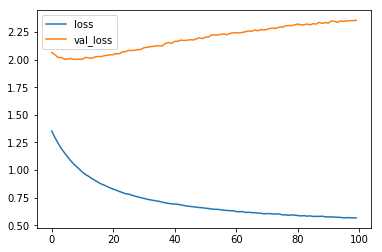

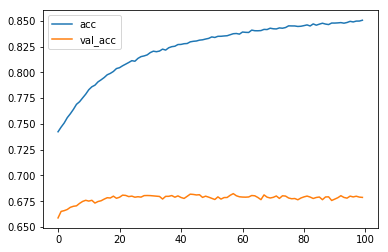

In [106]:
# plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

Apprently, we have overfit here. There are two ways to fix this:
    1. More data
    2. Make the model simpler

In [87]:
model.save('./data/s2s.h5')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


<font color='blue'>
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '

### Prediction Model

In [107]:
### prediction encoder model

#
encoder_model = Model(encoder_inputs_placeholder, encoder_state)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 9, 50)             178550    
_________________________________________________________________
lstm_3 (LSTM)                [(None, 128), (None, 128) 91648     
Total params: 270,198
Trainable params: 270,198
Non-trainable params: 0
_________________________________________________________________


In [108]:
### prediction decoder model

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input= [decoder_state_input_h, decoder_state_input_c]

# The input should be an integer representing the word predicted from previous time step
decoder_input_single = Input(shape=(1,))

# Reuse the decoder embedding layer when training but with different input
decoder_input_single_x = decoder_embedding(decoder_input_single)

# Reuse the decoder LSTM layer when training but with different input
# NOTE we have three outputs  
o, h, c = decoder_lstm(decoder_input_single_x, initial_state=decoder_state_input)

# We have three outputs from LSTM layer, But they belong to two category
#   1. h and c are hidden state and cell state respectively. 
#   2. o is the output for prediction
decoder_state_output = [h, c]

# Compute probabilty distribution over all words in the vocabulary
decoder_output = decoder_dense(o)

# IMPORTANT: what does the prediction model take as inputs and outputs?
# - Inputs:
#    1. A single word (represented as an integer) predicted from previous time step
#    2. Both hidden states and cell states from previous time step
# - Outputs:
#    1. Probability distribution over all words in the vocabulary. 
#        - This distribution is used to predict word at current time step.
#    2. Both hidden state and cell state produced at current time step.
#        - These states will be passed to the next time step
decoder_model = Model(
    [decoder_input_single] + decoder_state_input, 
    [decoder_output] + decoder_state_output
)

idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_chn = {v:k for k, v in word2idx_outputs.items()}

In [109]:
def decode_sequence(input_seq):
    
    # Encoder model predict states based on the source sequence (i.e., English)
    #  - The states can be considered as the compact representation of this source sequence
    state_value = encoder_model.predict(input_seq)
    
    # The first input to the LSTM
    pred_seq = np.zeros((1,1))
    pred_seq[0,0] = word2idx_outputs['S']
    
#     pred_seq = np.array([[word2index['<sos>']]])
        
    eos = word2idx_outputs['E']
    
    output_sentence = []
    
    # for each time step of the source sequence
    for _ in range(max_len_target):
        
        # decoder model predicts the output, hidden state and cell state based on 
        # the predicted (single) word (represented by index), hidden state and cell state from previous time step
        o, h, c = decoder_model.predict([pred_seq] + state_value)
        
        # the output o has shape of (batch_size, sequence_length, word_number)
        # But it actually has only 1 batch and 1 sequence length. It looks like:
        # [[[0.1, 0.2, 0.3, 0.3, 0.1]]]
        # We only need the probability distribution over all words
        probs = o[0, 0, :]
        
        # greedy way to find current most likely word
        #  - NOTE: a more robust way is to use Beam Search
        idx = np.argmax(probs)
        
        # If the predicted index is the 'end of sequence', the translation process is completed
        if eos == idx:
            break
        
        # Constructing the output sentence
        word = ''
        if idx > 0:
            word = idx2word_chn[idx]
            output_sentence.append(word)
        
        # Set the input for the next time step
        pred_seq[0,0] = idx
        state_value = [h, c]
        
    return ' '.join(output_sentence)

In [137]:
# Do some test translations
i = np.random.choice(len(input_texts))
encode_inputs
input_seq = encode_inputs[i:i+1]
print(input_seq.shape)
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[i])
print('Translation:', translation)

(1, 9)
-
Input: I'm used to working all night.
Translation: 我 晚 惯 睡 很 。


### Retrospect

The translation result is not satisfactory though it is working, because
* The model is not trained well enough: the accuracy (0.68) is not quite good
    * The model is overfitting
    * Not enough data
* May need `Beam Search` for translation (We currenly are using greedy search)
* The English syntax structure is quite different from that of Chinese
    * May need `Attention`